# Data processing

Get device info

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
!nvidia-smi

Wed May 31 00:18:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!nvidia-smi -L
!lscpu | grep 'Model name'
!lscpu | grep '^CPU(s)'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep 'Core(s) per socket'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'CPU MHz'
!awk 'NR==3 {printf "Available memory:\t\t %.fG\n",$2/1024^2}' /proc/meminfo
!df -h / | awk 'NR==2 {print "Available disk:\t\t\t "$4}'

GPU 0: Tesla T4 (UUID: GPU-68dc1b9f-2ecf-fabe-121d-cca7e2420bea)
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
CPU(s):                          8
Thread(s) per core:              2
Core(s) per socket:              4
Socket(s):                       1
CPU MHz:                         2000.152
Available memory:		 50G
Available disk:			 144G


Connect to Google drive and import dataset

In [4]:
%%capture
from google.colab import drive
drive.mount('drive')

In [5]:
import os

if not os.path.exists('data'):
  !mkdir 'data'
  !tar -xzf 'drive/MyDrive/classification/food-101.tar.gz' -C 'data'

Import modules

In [6]:
%%capture
%pip install timm==0.6.13

In [7]:
import gc
from pathlib import Path

import timm
from fastai.data.all import *
from fastai.vision.all import *

Find timm model

In [8]:
TIMM_MODELS = timm.list_models('*swin_base*')
TIMM_MODELS

['swin_base_patch4_window7_224',
 'swin_base_patch4_window7_224_in22k',
 'swin_base_patch4_window12_384',
 'swin_base_patch4_window12_384_in22k']

Declare constants

In [9]:
IMAGE_DIR = 'data/food-101/images'
META_DIR = 'data/food-101/meta'
TRAIN_SET = open(Path(META_DIR + '/train.txt')).read().split('\n')[:-1]
TEST_SET = open(Path(META_DIR + '/test.txt')).read().split('\n')[:-1]
CLASSES = open(Path(META_DIR + '/classes.txt')).read().split('\n')[:-1]

In [10]:
MODEL_NAME = TIMM_MODELS[0]

BATCH_SIZE = 64
METRICS = [error_rate, accuracy, top_k_accuracy]
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Dataloader function

In [11]:
item = (Resize(224))
batch = aug_transforms(size=224)

In [12]:
params = {'seed': 42, 'bs': BATCH_SIZE}

In [13]:
fnames = [f'{IMAGE_DIR}/{i}.jpg' for i in TRAIN_SET]
labels = [i.split('/')[0] for i in TRAIN_SET]

dls_train = ImageDataLoaders.from_lists(IMAGE_DIR, fnames, labels, 
                                        bs=BATCH_SIZE, seed=42,
                                        item_tfms=item, batch_tfms=batch,
                                        drop_last=False, device=DEVICE)

In [14]:
fnames = [f'{IMAGE_DIR}/{i}.jpg' for i in TEST_SET]
labels = [i.split('/')[0] for i in TEST_SET]

dls_test = ImageDataLoaders.from_lists(IMAGE_DIR, fnames, labels, 
                                       bs=BATCH_SIZE, seed=42, valid_pct=0,
                                       item_tfms=item, drop_last=False, 
                                       device=DEVICE)

# Model training

Train model

In [ ]:
swin = vision_learner(dls_train, MODEL_NAME, metrics=METRICS, device=DEVICE,
                      concat_pool=False)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth


In [ ]:
swin.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 128 x 56 x 56  
Conv2d                                    6272       False     
LayerNorm                                 256        True      
Dropout                                                        
LayerNorm                                 256        True      
____________________________________________________________________________
                     64 x 49 x 384       
Linear                                    49536      False     
Dropout                                                        
Linear                                    16512      False     
Dropout                                                        
Softmax                                                        
Identity                                                       
LayerNorm                                 256        True      
__________________________

In [ ]:
swin.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [CastToTensor]
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop

In [ ]:
swin.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.099135,0.667886,0.182310,0.817690,0.958416,07:02


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.744947,0.508512,0.136964,0.863036,0.970099,09:06


In [ ]:
swin.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.745803,0.537830,0.146007,0.853993,0.968845,07:12


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.653855,0.474366,0.129043,0.870957,0.974257,09:06
1,0.552304,0.450941,0.120924,0.879076,0.974984,09:06
2,0.470170,0.433202,0.116568,0.883432,0.975644,09:06


Evaluate model

In [ ]:
swin.validate(0, dls_test.train)

(#4) [0.36294272541999817,0.10106929391622543,0.8989306688308716,0.9861782193183899]

In [ ]:
fname = f'new_v3_{MODEL_NAME}'
mpath = swin.save(fname)
!cp $mpath 'drive/MyDrive/'$fname'.pth'
swin.export(f'{fname}.pkl')
!cp $IMAGE_DIR'/'$fname'.pkl' 'drive/MyDrive/'$fname'.pkl'

# Feature extraction

Load saved model

In [15]:
fname = f'new_v3_{MODEL_NAME}'
model_dir = f'{IMAGE_DIR}/models'
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
!cp 'drive/MyDrive/'$fname'.pth' $model_dir'/'$fname'.pth'
!cp 'drive/MyDrive/'$fname'.pth' '.'
!cp 'drive/MyDrive/'$fname'.pkl' '.'

In [16]:
learner = load_learner(f'{fname}.pkl', DEVICE=='cpu').load(fname)

In [ ]:
eval = learner.validate(0, dls_test.train)

In [ ]:
model = nn.Sequential(*list(learner.model.children()))[:-1]

In [ ]:
model

Sequential(
  (0): TimmBody(
    (model): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (0): BasicLayer(
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (mlp): Mlp(
     

In [ ]:
for param in model.parameters():
    param.requires_grad = False

Extract features

In [ ]:
BATCH_SIZE = 125

In [ ]:
fnames = [f'{IMAGE_DIR}/{i}.jpg' for i in TRAIN_SET]
labels = [i.split('/')[0] for i in TRAIN_SET]

dls_train = ImageDataLoaders.from_lists(IMAGE_DIR, fnames, labels, 
                                        bs=BATCH_SIZE, seed=42, valid_pct=0,
                                        item_tfms=item, batch_tfms=batch,
                                        drop_last=False, device=DEVICE)

In [ ]:
fnames = [f'{IMAGE_DIR}/{i}.jpg' for i in TEST_SET]
labels = [i.split('/')[0] for i in TEST_SET]

dls_test = ImageDataLoaders.from_lists(IMAGE_DIR, fnames, labels, 
                                       bs=BATCH_SIZE, seed=42, valid_pct=0,
                                       item_tfms=item, drop_last=False, 
                                       device=DEVICE)

In [ ]:
def feature_extractor(dl, m, num_batches):
  features, labels = [], []
  count = 1
  for x, y in iter(dl):
    if count % 100 == 0 or count == num_batches:
      print(count)
    out = m(x)
    features.extend(out.cpu().detach().numpy())
    labels.extend(y.cpu().detach().numpy())
    count += 1
  return [features, np.array(labels)]

In [ ]:
features = feature_extractor(dls_train.train, model, len(dls_train.train))
x_train = features[0]
y_train = features[1]

100
200
300
400
500
600
606


In [ ]:
features = feature_extractor(dls_test.train, model, len(dls_test.train)) 
x_test = features[0]
y_test = features[1]

100
200
202


In [ ]:
print(len(x_train), len(y_train), len(x_test), len(y_test))

75750 75750 25250 25250


# Classification

Dask client

In [ ]:
%%capture
%pip install dask-ml
%pip install dask-ml[complete]

In [ ]:
from dask.distributed import Client, progress

In [ ]:
client = Client()

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:37131
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44741'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35575'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43257'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:32821'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:35141', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:35141
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:51738
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45381', name: 1, status: 

In [ ]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 51.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37131,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 51.00 GiB
Comm: tcp://127.0.0.1:35141,Total threads: 2
Dashboard: http://127.0.0.1:34527/status,Memory: 12.75 GiB
Nanny: tcp://127.0.0.1:44741,


Create Dask array

In [ ]:
import dask.array as da

In [ ]:
da_x_train = da.from_array(x_train, chunks=(7575, 1024))
da_y_train = da.from_array(y_train, chunks=(7575,))
da_x_test = da.from_array(x_test, chunks=(2525, 1024))
da_y_test = da.from_array(y_test, chunks=(2525,))

SVM classifier

In [ ]:
import joblib

from dask_ml.model_selection import GridSearchCV
from dask_ml.metrics import accuracy_score
from dask_ml.wrappers import ParallelPostFit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [ ]:
C = [1, 10, 20, 100]

In [ ]:
for x in C:
  print(f'SVC with kernel=rbf and C={x}')
  svc = SVC(C=x)
  svc.fit(da_x_train, da_y_train)
  y_pred = svc.predict(da_x_test)
  print(f'accuracy: {str(accuracy_score(da_y_test, y_pred))}\n')

SVC with kernel=rbf and C=1
accuracy: 0.9104554455445545

SVC with kernel=rbf and C=10
accuracy: 0.9085544554455446

SVC with kernel=rbf and C=20
accuracy: 0.9075247524752476

SVC with kernel=rbf and C=100
accuracy: 0.9074851485148515



In [ ]:
for x in C:
  print(f'SVC with kernel=linear and C={x}')
  svc = SVC(C=x, kernel='linear')
  svc.fit(da_x_train, da_y_train)
  y_pred = svc.predict(da_x_test)
  print(f'accuracy: {str(accuracy_score(da_y_test, y_pred))}\n')

SVC with kernel=linear and C=1
accuracy: 0.893940594059406

SVC with kernel=linear and C=20
accuracy: 0.893940594059406

SVC with kernel=linear and C=100
accuracy: 0.893940594059406



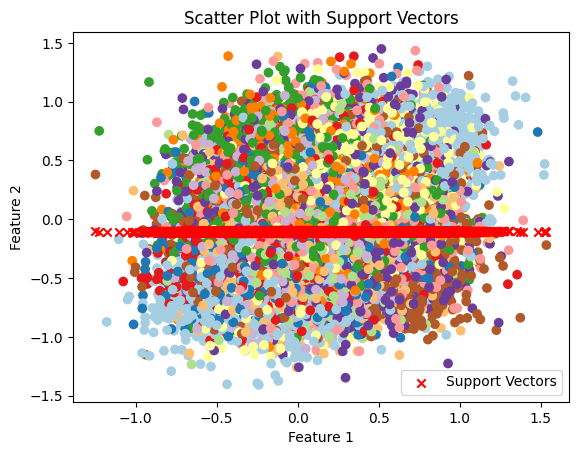

In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# Get the support vectors
support_vectors = svc.support_vectors_

# Plot the data points and support vectors
plt.scatter(da_x_train[:, 0], da_x_train[:, 1], c=da_y_train, cmap=plt.cm.Paired)
plt.scatter(support_vectors[:, 0], support_vectors[:, 2], color='red', marker='x', label='Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot with Support Vectors')
plt.legend()
plt.show()

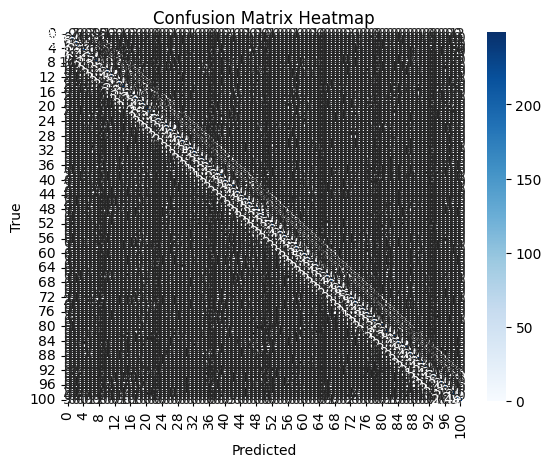

In [ ]:
import seaborn as sns
from sklearn import svm, datasets, metrics
from sklearn.model_selection import train_test_split

# Compute the confusion matrix
confusion_matrix = metrics.confusion_matrix(da_y_test, y_pred)

# Create a heatmap for the confusion matrix
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(da_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       250
           1       0.90      0.92      0.91       250
           2       0.92      0.93      0.92       250
           3       0.93      0.93      0.93       250
           4       0.86      0.89      0.87       250
           5       0.85      0.82      0.83       250
           6       0.92      0.95      0.93       250
           7       0.96      0.96      0.96       250
           8       0.76      0.79      0.78       250
           9       0.87      0.86      0.87       250
          10       0.88      0.89      0.88       250
          11       0.91      0.94      0.93       250
          12       0.96      0.97      0.97       250
          13       0.92      0.93      0.92       250
          14       0.86      0.91      0.88       250
          15       0.85      0.81      0.83       250
          16       0.96      0.96      0.96       250
          17       0.86    